## Importing Python Packages

In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter, ScalarFormatter, MaxNLocator
import numpy as np
import time
import gc
from IPython.display import HTML
import lightgbm as lgb
from sklearn.model_selection import KFold, RepeatedKFold
import itertools
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.linear_model import SGDRegressor
import xgboost
from catboost import Pool, CatBoostRegressor
import catboost
from sklearn.neural_network import MLPRegressor
import joblib

# to run the notebook in the cloud
import requests
import io

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
# is the notebook running locally or on the cloud?
# this will determine where to read the data from later
local = True 

# to determine if PCA will be used on pickup and drop-off
# one-hot-encoded features
pca_on_zones = True 

In [3]:
# some configurations for plotting

print(time.strftime('%H:%M'))

gc.enable()
%config InlineBackend.figure_format = 'retina'
plt.rc('figure', dpi=300)
plt.rc('savefig', dpi=300)
pd.set_option('display.max_columns', 100)
plt.style.use('default')
fig_size = (12,6)
big_fig_size = (18,8)
fig_fc = '#ffffff'
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
def plot_conf(ax, xlbl='', ylbl='', t=''):
    """
    This function perform operations to produce better-looking 
    visualizations
    """
    # changing the background color of the plot
    ax.set_facecolor('#ffffff')
    # modifying the ticks on plot axes
    ax.tick_params(axis='both', labelcolor='#616161', color='#ffffff')
    ax.tick_params(axis='both', which='major', labelsize=9)
    # adding a grid and specifying its color
    # ax.grid(True, color='#4d4a50')
    ax.grid(True, color='#e9e9e9')
    # making the grid appear behind the graph elements
    ax.set_axisbelow(True)
    # hiding axes
    ax.spines['bottom'].set_color('#ffffff')
    ax.spines['top'].set_color('#ffffff') 
    ax.spines['right'].set_color('#ffffff')
    ax.spines['left'].set_color('#ffffff')
    # setting the title, x label, and y label of the plot
    ax.set_title(t, fontsize=14, color='#616161', loc='left', pad=24, fontweight='bold');
    ax.set_xlabel(xlbl, labelpad=16, fontsize=11, color='#616161', fontstyle='italic');
    ax.set_ylabel(ylbl, color='#616161', labelpad=16, fontsize=11, fontstyle='italic');
     
styles = [
    dict(selector="td, th", props=[("border", "1px solid #333"), ("padding", "6px")]),
    dict(selector="td", props=[('background', '#fdf6e3')]),
    dict(selector="th.col_heading", props=[("background", "#002b36"), 
                                           ("color", "#b58900"), ("padding", "10px 16px")]),
    dict(selector="th.index_name", props=[("background", "#002b36"), 
                                          ("color", "#268bd2"), ("padding", "10px 16px")]),
    dict(selector="th.blank", props=[("background", "#002b36"), 
                                     ("color", "#268bd2"), ("padding", "10px 16px")]),
    dict(selector="th.row_heading.level0", props=[("background", "rgba(133, 153, 0, 0.1)")]),
    dict(selector="th.row_heading.level1", props=[("background", "rgba(42, 161, 152, 0.1)")]),
    dict(selector="thead tr:nth-child(2) th", props=[("border-bottom", "3px solid #333333")]),
    dict(selector="td:hover", props=[("font-weight", "bold"), 
                                     ("background", "#002b36"), ("color", "Gold")]),
]

def style_datfr(datfr):
    display(datfr.style.set_table_styles(styles).set_table_attributes(
        'style="border-collapse: collapse; border: 1px solid black"')
            .format('{:,}').set_caption(''))

if local:
    # change this to your desired location to save resulting visulaizations there
    rep_files_p = '/Users/ammar/Documents/CS-and-work/UM MDatSc/Research Project/Report-Files/'
else:
    rep_files_p = './'

21:28


## Reading the Data

In [4]:
# if running the notebook on local machine
# change the file paths to the paths on your machine

if local:
    data = pd.read_csv('./yellow_tripdata_2017-03_processed.csv', 
                       parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

    test_data = pd.read_csv('./yellow_tripdata_2018-03_processed.csv', 
                            parse_dates=['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

    weather_data = pd.read_csv('./NY_central_park_weather_2017-03_processed.csv', 
                               parse_dates=['Date'])

    weather_test_data = pd.read_csv('./NY_central_park_weather_2018-03_processed.csv', 
                                    parse_dates=['Date'])

    zones_lookup_table = pd.read_csv('./NYC_taxi_data/additional_files/taxi_zone_lookup.csv')

# if running the notebook on the cloud; can be used when running locally too
else:
    base_url = 'https://storage.googleapis.com/research_project_um/'
    res = requests.get('{}yellow_tripdata_2017-03_processed.csv'.format(base_url))
    res_f = io.BytesIO(res.content)
    data = pd.read_csv(res_f, parse_dates=
                       ['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

    res = requests.get('{}yellow_tripdata_2018-03_processed.csv'.format(base_url))
    res_f = io.BytesIO(res.content)
    test_data = pd.read_csv(res_f, parse_dates=
                            ['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

    res = requests.get('{}NY_central_park_weather_2017-03_processed.csv'.format(base_url))
    res_f = io.BytesIO(res.content)
    weather_data = pd.read_csv(res_f, parse_dates=['Date'])

    res = requests.get('{}NY_central_park_weather_2018-03_processed.csv'.format(base_url))
    res_f = io.BytesIO(res.content)
    weather_test_data = pd.read_csv(res_f, parse_dates=['Date'])

    res = requests.get('{}taxi_zone_lookup.csv'.format(base_url))
    res_f = io.BytesIO(res.content)
    zones_lookup_table = pd.read_csv(res_f)

### Keeping only the data of the first five days of each month

In [5]:
data = data[(data.tpep_pickup_datetime.dt.day.isin([1,4,5])) & 
            (data.tpep_pickup_datetime.dt.hour.between(13,23))].reset_index(drop=True)

test_data = test_data[(test_data.tpep_pickup_datetime.dt.day.isin([1,4,5])) & 
                      (test_data.tpep_pickup_datetime.dt.hour.between(13,23))].reset_index(drop=True)

weather_data = weather_data[(weather_data.Date.dt.day.isin([1,4,5]))].reset_index(drop=True)

weather_test_data = weather_test_data[(weather_test_data.Date.dt.day.isin([1,4,5]))].reset_index(drop=True)

In [6]:
data.shape, test_data.shape

((611114, 18), (522170, 18))

In [7]:
weather_data.shape, weather_test_data.shape

((3, 10), (3, 10))

In [8]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration
0,1,2017-03-01 13:00:00,2017-03-01 13:10:12,1,2.25260,1,N,236,237,2,8.5,0.0,0.5,0.00,0.00,0.3,9.30,10.200000
1,1,2017-03-01 13:00:00,2017-03-01 13:48:34,1,35.07620,2,N,132,142,2,52.0,0.0,0.5,0.00,5.54,0.3,58.34,48.566667
2,1,2017-03-01 13:00:00,2017-03-01 13:11:20,1,1.60900,1,N,234,170,1,8.5,0.0,0.5,1.85,0.00,0.3,11.15,11.333333
3,2,2017-03-01 13:00:00,2017-03-01 13:00:55,1,0.33789,1,N,263,236,2,3.0,0.0,0.5,0.00,0.00,0.3,3.80,0.916667
4,2,2017-03-01 13:00:00,2017-03-01 13:08:57,5,1.38374,1,N,43,161,1,7.0,0.0,0.5,1.56,0.00,0.3,9.36,8.950000


In [9]:
weather_data.head()

,Date,Maximum Temperature,Minimum Temperature,Average Temperature,Departure Temperature,HDD,CDD,Precipitation,New Snow,Snow Depth
0,2017-03-01,21.111111,12.222222,16.666667,-4.500000,3,0,0.3048,0.0,0.0
1,2017-03-04,-1.111111,-8.333333,-4.722222,-26.277778,41,0,0.0000,0.0,0.0
2,2017-03-05,2.777778,-10.000000,-3.611111,-25.333333,39,0,0.0000,0.0,0.0


## Feature Selection

In [10]:
data[data.RatecodeID != 99].shape[0], test_data[test_data.RatecodeID != 99].shape[0]

(611114, 522170)

In [11]:
# deleting records with missing rate-code ID (i.e. where
# rate-code ID is equal to 99)
data = data[data.RatecodeID != 99]
test_data = test_data[test_data.RatecodeID != 99]

In [12]:
data.shape[0], test_data.shape[0]

(611114, 522170)

In [13]:
(data[(data.PULocationID >= 264) | (data.DOLocationID >= 264)].shape[0], 
 test_data[(test_data.PULocationID >= 264) | (test_data.DOLocationID >= 264)].shape[0])

(12707, 9081)

In [14]:
zones_lookup_table[zones_lookup_table.LocationID >= 264]

,LocationID,Borough,Zone,service_zone
263,264,Unknown,NV,NaN
264,265,Unknown,NaN,NaN


In [15]:
# deleting records that contain location ID 264 or 265 because they
# represent erroneous locations
data = data[(~data.PULocationID.isin([264, 265])) & (~data.DOLocationID.isin([264, 265]))]
test_data = test_data[(~test_data.PULocationID.isin([264, 265])) & 
                      (~test_data.DOLocationID.isin([264, 265]))]

In [16]:
data.shape[0], test_data.shape[0]

(598407, 513089)

In [17]:
data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

### Dropping irrelevant columns

In [18]:
cols_to_drop = ['tpep_dropoff_datetime', 'trip_distance', 'RatecodeID', 
                'store_and_fwd_flag', 'payment_type', 'fare_amount', 'extra', 
                'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 
                'total_amount']

for df in (data, test_data):
    df.drop(cols_to_drop, axis=1, inplace=True)
    
for df in (weather_data, weather_test_data):
    df.drop(['Departure Temperature', 'HDD', 'CDD'], axis=1, inplace=True)

In [19]:
print(data.shape)
data.head()

(598407, 6)


,VendorID,tpep_pickup_datetime,passenger_count,PULocationID,DOLocationID,trip_duration
0,1,2017-03-01 13:00:00,1,236,237,10.200000
1,1,2017-03-01 13:00:00,1,132,142,48.566667
2,1,2017-03-01 13:00:00,1,234,170,11.333333
3,2,2017-03-01 13:00:00,1,263,236,0.916667
4,2,2017-03-01 13:00:00,5,43,161,8.950000


In [20]:
print(weather_data.shape)
weather_data.head()

(3, 7)


,Date,Maximum Temperature,Minimum Temperature,Average Temperature,Precipitation,New Snow,Snow Depth
0,2017-03-01,21.111111,12.222222,16.666667,0.3048,0.0,0.0
1,2017-03-04,-1.111111,-8.333333,-4.722222,0.0000,0.0,0.0
2,2017-03-05,2.777778,-10.000000,-3.611111,0.0000,0.0,0.0


## Feature Engineering

### Extract features from datetime fields

In [21]:
# used to create a feature below
is_weekend_dict = {'Monday': 'No', 'Tuesday': 'No', 'Wednesday': 'No', 
                   'Thursday': 'No', 'Friday': 'No', 'Saturday': 'Yes', 
                   'Sunday': 'Yes'}

# performing the operations on training and test data
for df in [data, test_data]:
    df['pickup_day_of_month'] = df.tpep_pickup_datetime.dt.day
    df['pickup_hour'] = df.tpep_pickup_datetime.dt.hour
    df['pickup_period_of_day'] = pd.cut(
        df.tpep_pickup_datetime.dt.hour, [0,2,5,8,11,14,17,20,23], include_lowest=True,
        labels=['0_2','3_5','6_8','9_11','12_14','15_17','18_20','21_23'])
    df['pickup_day_name'] = df.tpep_pickup_datetime.dt.day_name()
    df['pickup__is_weekend'] = df.pickup_day_name.map(is_weekend_dict)
    # deleting the original field 
    df.drop('tpep_pickup_datetime', axis=1, inplace=True)

In [22]:
data.head()

,VendorID,passenger_count,PULocationID,DOLocationID,trip_duration,pickup_day_of_month,pickup_hour,pickup_period_of_day,pickup_day_name,pickup__is_weekend
0,1,1,236,237,10.200000,1,13,12_14,Wednesday,No
1,1,1,132,142,48.566667,1,13,12_14,Wednesday,No
2,1,1,234,170,11.333333,1,13,12_14,Wednesday,No
3,2,1,263,236,0.916667,1,13,12_14,Wednesday,No
4,2,5,43,161,8.950000,1,13,12_14,Wednesday,No


### Temperature features

In [23]:
for (df, w_df) in [(data, weather_data), (test_data, weather_test_data)]:
    day_temp = {}
    for d, t in zip(w_df.Date.dt.day, w_df['Average Temperature']):
        day_temp[d] = t
    df['day_avg_temperature'] = df.pickup_day_of_month.map(day_temp)
    
    day_temp_range = {}
    for d, mx_t, mn_t in zip(w_df.Date.dt.day, w_df['Maximum Temperature'], 
                    w_df['Minimum Temperature']):
        day_temp_range[d] = mx_t - mn_t
    df['day_temperature_range'] = df.pickup_day_of_month.map(day_temp_range)

### Precipitation features

In [24]:
for (df, w_df) in [(data, weather_data), (test_data, weather_test_data)]:
    day_prec = {}
    for d, p in zip(w_df.Date.dt.day, w_df['Precipitation']):
        day_prec[d] = p
    df['day_precipitation'] = df.pickup_day_of_month.map(day_prec)
    
    day_new_snow = {}
    for d, ns in zip(w_df.Date.dt.day, w_df['New Snow']):
        day_new_snow[d] = ns
    df['day_new_snow'] = df.pickup_day_of_month.map(day_new_snow)
    
    day_snow_depth = {}
    for d, sd in zip(w_df.Date.dt.day, w_df['Snow Depth']):
        day_snow_depth[d] = sd
    df['day_snow_depth'] = df.pickup_day_of_month.map(day_snow_depth)

### More features

In [25]:
for df in (data, test_data):
    # is the number of passengers > 6?
    df['is_passenger_count_gt_6'] = df['passenger_count'].apply(
        lambda x: 1 if x > 6 else 0)

#### Borough and servie-zone features

In [26]:
locID_borough_map = {}
locID_service_zone_map = {}
for loc_id, b, sz in zip(zones_lookup_table.LocationID.tolist(), 
                         zones_lookup_table.Borough.tolist(),
                         zones_lookup_table.service_zone.tolist()):
    locID_borough_map[loc_id] = b
    locID_service_zone_map[loc_id] = sz


for df in [data, test_data]:
    df['pickup_borough'] = df['PULocationID'].map(locID_borough_map)
    df['dropoff_borough'] = df['DOLocationID'].map(locID_borough_map)
    df['pickup_service_zone'] = df['PULocationID'].map(locID_service_zone_map)
    df['dropoff_service_zone'] = df['DOLocationID'].map(locID_service_zone_map)    

### One-hot encoding and label encoding

In [27]:
data.head()

,VendorID,passenger_count,PULocationID,DOLocationID,trip_duration,pickup_day_of_month,pickup_hour,pickup_period_of_day,pickup_day_name,pickup__is_weekend,day_avg_temperature,day_temperature_range,day_precipitation,day_new_snow,day_snow_depth,is_passenger_count_gt_6,pickup_borough,dropoff_borough,pickup_service_zone,dropoff_service_zone
0,1,1,236,237,10.200000,1,13,12_14,Wednesday,No,16.666667,8.888889,0.3048,0.0,0.0,0,Manhattan,Manhattan,Yellow Zone,Yellow Zone
1,1,1,132,142,48.566667,1,13,12_14,Wednesday,No,16.666667,8.888889,0.3048,0.0,0.0,0,Queens,Manhattan,Airports,Yellow Zone
2,1,1,234,170,11.333333,1,13,12_14,Wednesday,No,16.666667,8.888889,0.3048,0.0,0.0,0,Manhattan,Manhattan,Yellow Zone,Yellow Zone
3,2,1,263,236,0.916667,1,13,12_14,Wednesday,No,16.666667,8.888889,0.3048,0.0,0.0,0,Manhattan,Manhattan,Yellow Zone,Yellow Zone
4,2,5,43,161,8.950000,1,13,12_14,Wednesday,No,16.666667,8.888889,0.3048,0.0,0.0,0,Manhattan,Manhattan,Yellow Zone,Yellow Zone


In [28]:
data.PULocationID.unique().shape[0]

223

In [29]:
# columns to be used for one-hot encoding
cols_for_onehot_enc = ['VendorID', 'PULocationID', 'DOLocationID', 'pickup_day_name',
                       'pickup_borough', 'dropoff_borough', 'pickup_service_zone', 
                       'dropoff_service_zone', 'pickup_period_of_day', 'pickup_day_of_month']

onehot_col_prefixes = {x:x for x in cols_for_onehot_enc}

# columns to be used for label encoding
cols_for_label_enc = ['pickup__is_weekend']

# columns to be used for target encoding later
cols_for_target_enc = ['PULocationID', 'DOLocationID', 'pickup_period_of_day', 'pickup_hour']

# columns for both one-hot encoding and target encoding
cols_targetend_and_onehot = [x for x in cols_for_target_enc if x in cols_for_onehot_enc]

In [30]:
# performing one-hot encoding and label encoding while keeping the
# columns that will be used for target encoding later

# one-hot encoding: training data
tmp_cols = data[cols_targetend_and_onehot]

data = pd.get_dummies(data, columns=cols_for_onehot_enc, 
                      prefix=onehot_col_prefixes, prefix_sep='__')
for c in tmp_cols:
    data[c] = tmp_cols[c].values
    
# one-hot encoding: test data
tmp_cols = test_data[cols_targetend_and_onehot]

test_data = pd.get_dummies(test_data, columns=cols_for_onehot_enc, 
                           prefix=onehot_col_prefixes, prefix_sep='__')

for c in tmp_cols:
    test_data[c] = tmp_cols[c].values
    
# label encoding
for df in (data, test_data):
    for c in cols_for_label_enc:
        df[c] = pd.factorize(df[c])[0]
        
display(data.shape, test_data.shape)

(598407, 528)

(513089, 530)

In [31]:
# align data and test_data (making sure they have the same 
# columns) after one-hot encoding
missing_cols = set(data.columns) - set(test_data.columns)
for c in missing_cols:
    test_data[c] = 0

missing_cols = set(test_data.columns) - set(data.columns)
for c in missing_cols:
    data[c] = 0
    
# to ensure the same column order also
test_data = test_data[data.columns]

In [32]:
data.shape, test_data.shape

((598407, 542), (513089, 542))

### Performing PCA on location-zones (i.e. location-IDs) features

In [33]:
if pca_on_zones:
    n_comp = 130
    locid_cols = [c for c in data.columns 
                  if (c.startswith('PULocationID__') or c.startswith('DOLocationID__'))]
    tmp_data = data[locid_cols]
    data.drop(locid_cols, axis=1, inplace=True)
    pca = PCA(random_state=7, svd_solver='randomized', n_components=n_comp).fit(tmp_data)
    
    # save pca model for deployment
    joblib.dump(pca, 'pca_zones.joblib')
    
    tmp_cls = ['PUDOLocIdPCA_{}'.format(x) for x in range(1,n_comp+1)]
    tmp_data = pd.DataFrame(pca.transform(tmp_data), columns=tmp_cls)
    data = pd.concat([data, tmp_data], axis=1)

    locid_cols = [c for c in test_data.columns 
                  if (c.startswith('PULocationID__') or c.startswith('DOLocationID__'))]
    tmp_data = test_data[locid_cols]
    
    test_data.drop(locid_cols, axis=1, inplace=True)
    tmp_cls = ['PUDOLocIdPCA_{}'.format(x) for x in range(1,n_comp+1)]
    tmp_data = pd.DataFrame(pca.transform(tmp_data), columns=tmp_cls)
    test_data = pd.concat([test_data, tmp_data], axis=1)

### Adding more features after feature encoding

In [34]:
# features that indicate the origin and destination boroughs of the trip
for df in (data, test_data):
    cols_pickup_bor = [c for c in df.columns if c.startswith('pickup_borough__')]
    cols_dropoff_bor = [c for c in df.columns if c.startswith('dropoff_borough__')]
    for cp, cd in itertools.product(cols_pickup_bor, cols_dropoff_bor):
        df[cp + '_x_' + cd] = df[cp] * df[cd]

In [35]:
data.shape, test_data.shape

((598407, 217), (513089, 217))

### Removing features that have one unique value only for all trips

In [36]:
cols_with_one_val = []
for c in data.columns:
    if (data[c].unique().shape[0] == 1) and (test_data[c].unique().shape[0] == 1):
        cols_with_one_val.append(c)
data.drop(cols_with_one_val, axis=1, inplace=True)
test_data.drop(cols_with_one_val, axis=1, inplace=True)

In [37]:
data.shape, test_data.shape

((598407, 202), (513089, 202))

## Building the Final Ensemble Model

In [38]:
# target encoding
for col in cols_for_target_enc:
    means = data.groupby(col).trip_duration.mean()
    data[col + '_mean_encoded'] = data[col].map(means)
    test_data[col + '_mean_encoded'] = test_data[col].map(means)

    medians = data.groupby(col).trip_duration.agg(lambda ser: np.median(ser))
    data[col + '_median_encoded'] = data[col].map(medians)
    test_data[col + '_median_encoded'] = test_data[col].map(medians)

    stds = data.groupby(col).trip_duration.std(ddof=0)
    data[col + '_std_encoded'] = data[col].map(stds)
    test_data[col + '_std_encoded'] = test_data[col].map(stds)

    mins = data.groupby(col).trip_duration.min()
    data[col + '_min_encoded'] = data[col].map(mins)
    test_data[col + '_min_encoded'] = test_data[col].map(mins)

    maxs = data.groupby(col).trip_duration.max()
    data[col + '_max_encoded'] = data[col].map(maxs)
    test_data[col + '_max_encoded'] = test_data[col].map(maxs)

    data.drop(col, axis=1, inplace=True)
    test_data.drop(col, axis=1, inplace=True)    

# data = data.drop('trip_duration', axis=1)
# test_data = test_data.drop('trip_duration', axis=1)

target_endoded_vars = [x for x in test_data.columns if 
                       x.endswith(('_mean_encoded', '_median_encoded', 
                                   '_std_encoded', '_min_encoded', 
                                   '_max_encoded'))]

test_data[target_endoded_vars] = test_data[target_endoded_vars].fillna(-1)

In [39]:
# dividing the test data to build the ensemble model
test_data_shuffled = test_data.sample(frac=1.0).reset_index(drop=True)
test_data_ = test_data.copy()
test_data = test_data_shuffled.iloc[0:int(0.55 * test_data_shuffled.shape[0])]
validation_data = test_data_shuffled.iloc[int(0.55 * test_data_shuffled.shape[0]):]

In [40]:
# LightGBM model

print(time.strftime('%H:%M'))

train_data = lgb.Dataset(data.drop('trip_duration', axis=1), label=data.trip_duration)

# the optimized parameters
params={'learning_rate': 0.05, 'objective': 'regression_l1', 'num_leaves': 100, 
        'max_depth': 8, 'min_data_in_leaf': 20, 'bagging_freq': 1, 'bagging_fraction': 0.8, 
        'feature_fraction': 0.8, 'verbosity': -1, 'verbose': -1, 'random_state': 311, 
        'metric': '', 'num_threads': 2, 'boosting': 'gbdt'}
num_round = 500

light = lgb.train(params, train_data, num_round)

light_val_pred = light.predict(validation_data.drop('trip_duration', axis=1))
light_test_pred = light.predict(test_data.drop('trip_duration', axis=1))

print('LightGBM Validation MAE =', mean_absolute_error(light_val_pred, validation_data.trip_duration))

# saving the model for deployment
light.save_model('light_model.txt')

print(time.strftime('%H:%M'))

21:31
LightGBM Validation MAE = 3.166682961229847
21:33


In [41]:
# XGBoost model

print(time.strftime('%H:%M'))

dtrain = xgboost.DMatrix(data.drop('trip_duration', axis=1), label=data.trip_duration)
dvalidation = xgboost.DMatrix(validation_data.drop('trip_duration', axis=1))
dtest = xgboost.DMatrix(test_data.drop('trip_duration', axis=1))

# the optimized parameters
params = {'learning_rate': 0.1, 'eval_metric': 'mae', 'max_depth': 8, 'min_child_weight': 2, 
          'subsample': 0.8, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 
          'lambda': 1.0, 'alpha': 10.0, 'objective': 'reg:squarederror', 'nthread': 2, 
          'verbosity': 0, 'seed': 3}
num_round = 500

xgb = xgboost.train(params, dtrain, num_round)

xgb_val_pred = xgb.predict(dvalidation)
xgb_test_pred = xgb.predict(dtest)

# print('XGBoost MAE =', mean_absolute_error(xgb_pred, test_data.trip_duration))
print('XGBoost Validation MAE =', mean_absolute_error(xgb_val_pred, validation_data.trip_duration))

# saving the model for deployment
xgb.save_model('xgb_model.txt')

print(time.strftime('%H:%M'))

21:33
XGBoost Validation MAE = 3.291853825784393
22:15


In [44]:
scaler = StandardScaler()
scaler.fit(np.column_stack((light_val_pred, xgb_val_pred)))
# save the scaler
joblib.dump(scaler, 'scaler_meta_svr.joblib')
stacked_predictions_scaled = scaler.transform(np.column_stack((light_val_pred, xgb_val_pred)))
stacked_test_predictions_scaled = scaler.transform(np.column_stack((light_test_pred, xgb_test_pred)))

svr = LinearSVR(epsilon=0, tol=1e-4, C=1.0,
                loss='epsilon_insensitive', fit_intercept=True,
                intercept_scaling=1., dual=True, verbose=0,
                random_state=3, max_iter=2000)

svr.fit(stacked_predictions_scaled, validation_data.trip_duration)

ts_svr_pred = svr.predict(stacked_test_predictions_scaled)

# save the meta model
joblib.dump(svr, 'svr_meta_model.joblib')

params = {'learning_rate': 0.05, 'objective': 'regression_l1', 'num_leaves': 70, 
          'max_depth': 7, 'min_data_in_leaf': 500, 'bagging_freq': 1, 'bagging_fraction': 0.8, 
          'feature_fraction': 1.0, 'verbosity': -1, 'verbose': -1, 'random_state': 311, 
          'metric': '', 'num_threads': 2, 'boosting': 'gbdt'}

stacked_predictions_dataset = lgb.Dataset(np.column_stack((light_val_pred, xgb_val_pred)), 
                                          label=validation_data.trip_duration)

stacked_test_predictions = np.column_stack((light_test_pred, xgb_test_pred))

num_round = 500

light_m = lgb.train(params, stacked_predictions_dataset, num_round)

ts_light_pred = light_m.predict(stacked_test_predictions)

# save the meta model
light_m.save_model('lgb_meta_model.txt')

ts_pred = (ts_svr_pred + ts_light_pred) / 2

print('Ensemble-model MAE =', mean_absolute_error(ts_pred, test_data.trip_duration))    

Ensemble-model MAE = 3.0964610036768154


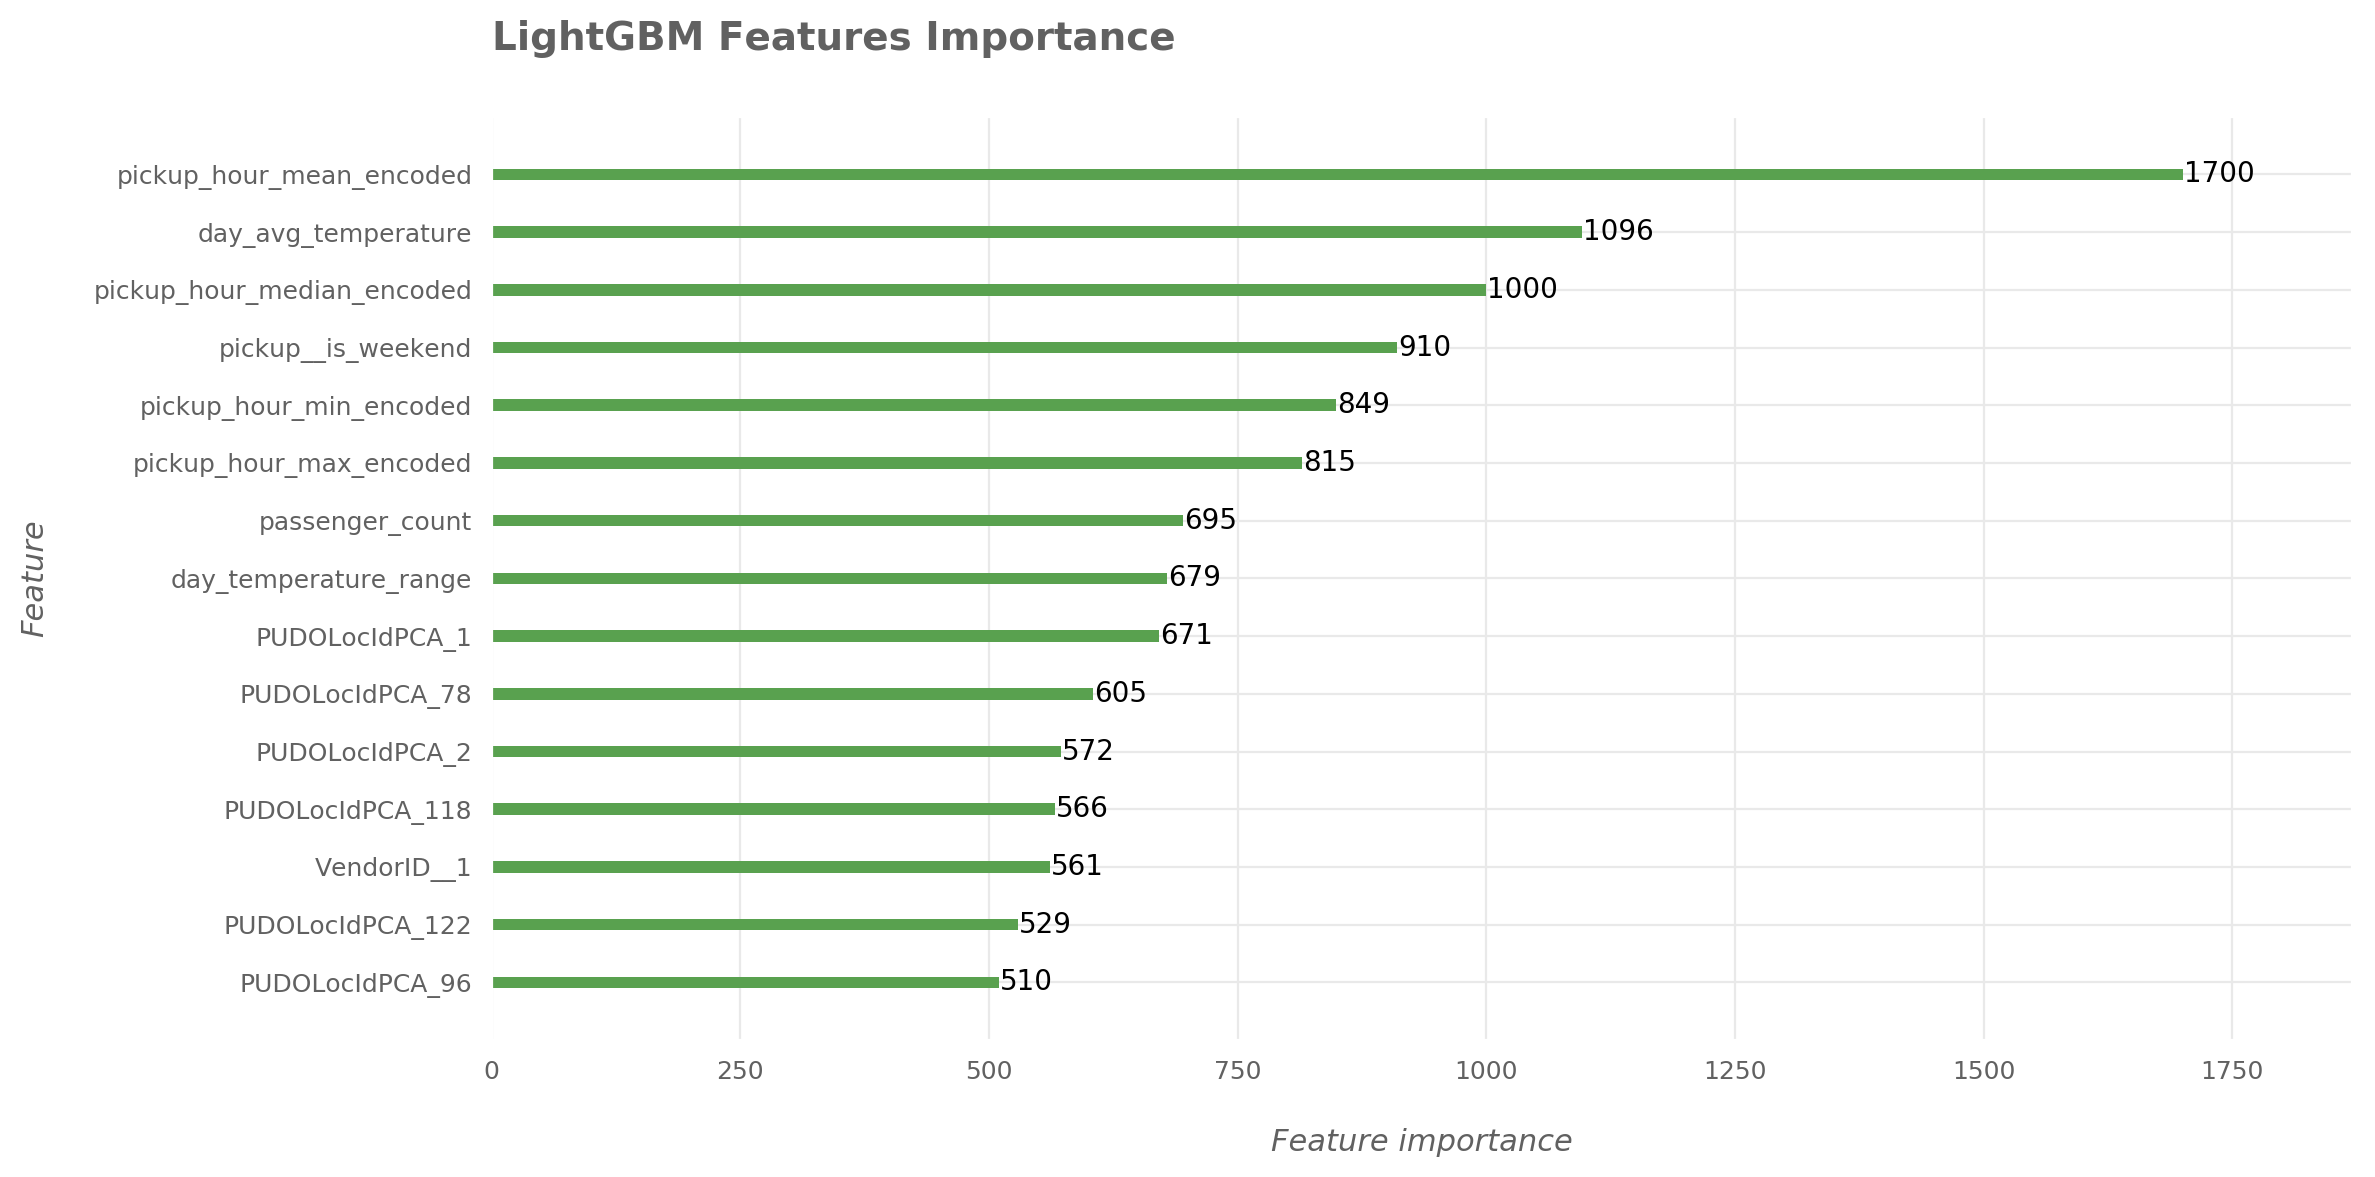

In [70]:
# lightBGM feature importance
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
lgb.plot_importance(light, max_num_features=15, ax=ax, title='', xlabel='', ylabel='', color='#59A14F')
plot_conf(ax, xlbl='Feature importance', ylbl='Feature', t='LightGBM Features Importance')
plt.tight_layout()
fig.savefig('{}lgbfeatimp.png'.format(rep_files_p), dpi=300)

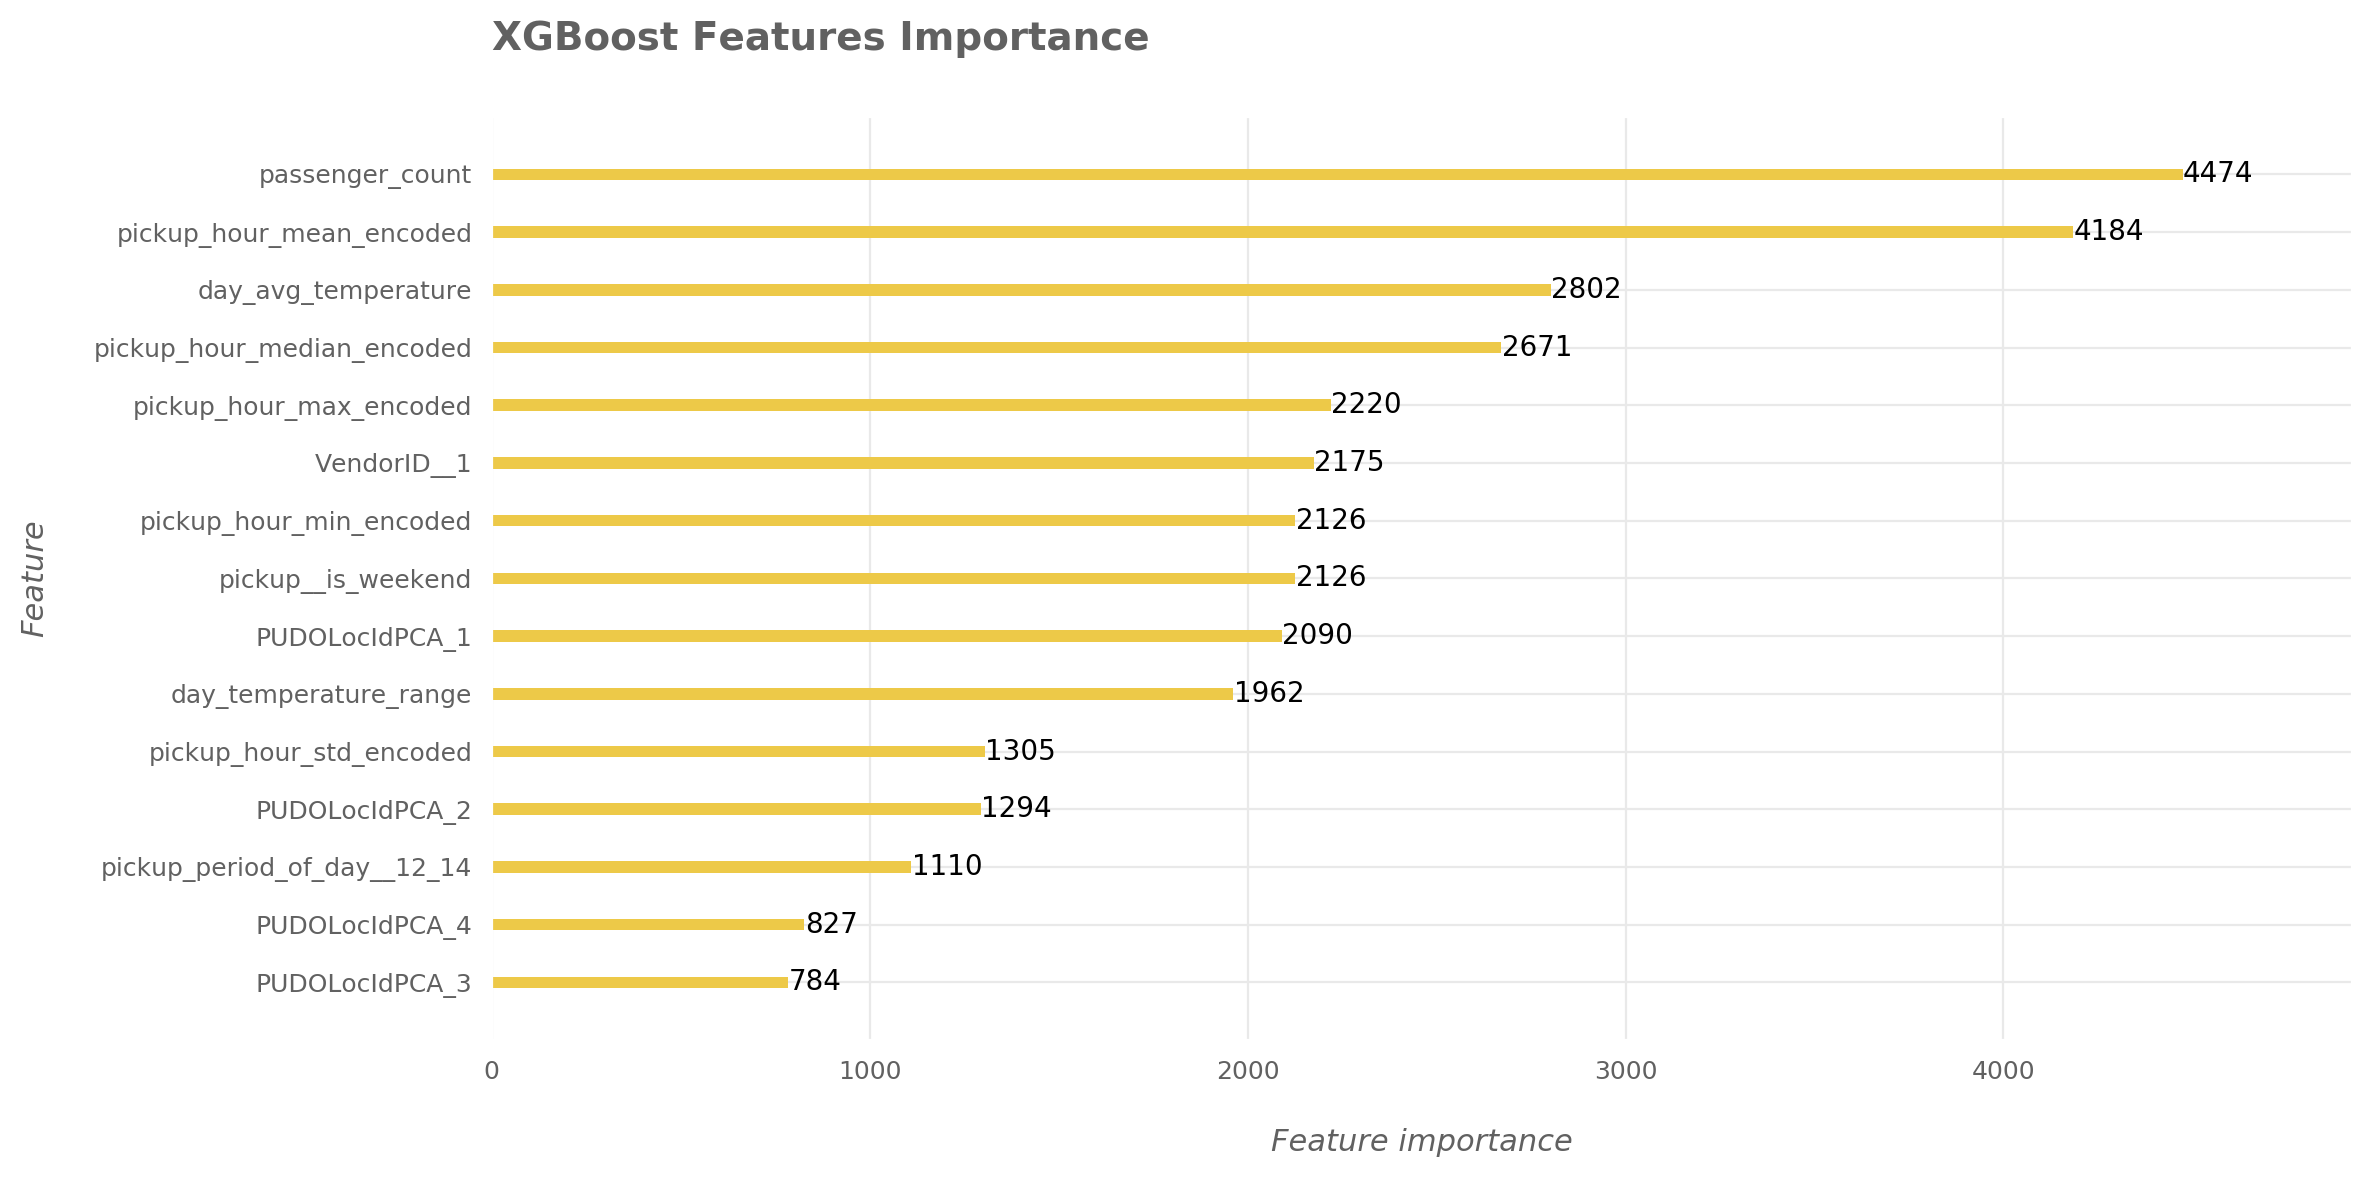

In [71]:
# XGBoost feature importance
fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
xgboost.plot_importance(xgb, max_num_features=15, ax=ax, title='', xlabel='', ylabel='', color='#EDC948')
plot_conf(ax, xlbl='Feature importance', ylbl='Feature', t='XGBoost Features Importance')
plt.tight_layout()
fig.savefig('{}xgbfeatimp.png'.format(rep_files_p), dpi=300)

In [69]:
# # XGBoost tree
# fig, ax = plt.subplots(figsize=fig_size, facecolor=fig_fc)
# xgboost.plot_tree(xgb, ax=ax)
# plot_conf(ax, xlbl='Feature importance', ylbl='Feature', t='XGBoost Features Importance')
# fig.savefig('{}xgbtree.png'.format(rep_files_p), dpi=300)